In [69]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

1)  Aqui vou tentar aplicar minha primeira ideia: 

    $x_i := $ valor medido no tempo i do retorno logaritmico daquele ativo


    $ E[X_t] = \frac{1}{N}\sum_{i= t-N}^{t-1}(x_i) = \overline{x}$


    $ \sigma_t^2 = \frac{1}{N-1}\sum_{i= t-N}^{t-1}(x_i - \overline{x})^2 $

    * Perceba que N é um hiperparâmetro

* Vamos aplicar essa estratégia para as seguintes criptos:

* Para o tempo de retorno, vamos escolher um período de x_days dias entre um trade e outro.

* Podemos adaptar esse período no futuro, encontrando um valor ótimo.

In [70]:
## Hiperparâmetros: 

N = 61  # intervalo de tempo para considerarmos a média
x_days = 1  # intervalo de dias que desejamos realizar as operações

In [71]:
# Importando os dados da Bitcoin e da Etherium e então adicionando uma coluna que representa o retorno logaritmico 
# Além disso, vamos aplicar o método de resemple para agregar os valores em 7 e 7 dias

resample_period = f'{x_days}D'


symbol = 'BTC-USD'
start_date = '2010-01-01'
end_date = '2022-12-31'
data_BTC = yf.download(symbol, start=start_date, end=end_date)
data_BTC= data_BTC.resample(resample_period).agg({'Open': 'first', 'Close': 'last'})
#data_BTC['Total Return'] = data_BTC['Close'] / data_BTC['Open']
data_BTC['Log Return'] = (data_BTC['Close'] / data_BTC['Open']).apply(math.log)
data_BTC['Percentual Return'] = ((data_BTC['Close'] - data_BTC['Open'])/data_BTC['Open'])

symbol = 'ETH-USD'
start_date = '2010-01-01'
end_date = '2022-12-31'
data_ETH = yf.download(symbol, start=start_date, end=end_date)
data_ETH= data_ETH.resample(resample_period).agg({'Open': 'first', 'Close': 'last'})
#data_ETH['Total Return'] = data_ETH['Close'] / data_ETH['Open']
data_ETH['Log Return'] = (data_ETH['Close'] / data_ETH['Open']).apply(math.log)
data_ETH['Percentual Return'] = ((data_ETH['Close'] - data_ETH['Open'])/data_ETH['Open'])

data_BTC.head(), data_ETH.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(                  Open       Close  Log Return  Percentual Return
 Date                                                             
 2014-09-17  465.864014  457.334015   -0.018480          -0.018310
 2014-09-18  456.859985  424.440002   -0.073606          -0.070963
 2014-09-19  424.102997  394.795990   -0.071607          -0.069104
 2014-09-20  394.673004  408.903992    0.035423           0.036058
 2014-09-21  408.084991  398.821014   -0.022963          -0.022701,
                   Open       Close  Log Return  Percentual Return
 Date                                                             
 2017-11-09  308.644989  320.884003    0.038888           0.039654
 2017-11-10  320.670990  299.252991   -0.069126          -0.066791
 2017-11-11  298.585999  314.681000    0.052501           0.053904
 2017-11-12  314.690002  307.907990   -0.021787          -0.021551
 2017-11-13  307.024994  316.716003    0.031076           0.031564)

In [72]:
# Plotanto a descrição desses retornos
print("\nEtherium Log Return description:\n")
print(data_ETH['Log Return'].describe())
print("\nBitcoin Log Return description:\n")
print(data_BTC['Log Return'].describe())


Etherium Log Return description:

count    1878.000000
mean        0.000598
std         0.051384
min        -0.550066
25%        -0.022234
50%         0.000986
75%         0.026762
max         0.230725
Name: Log Return, dtype: float64

Bitcoin Log Return description:

count    3027.000000
mean        0.001103
std         0.038562
min        -0.465006
25%        -0.013639
50%         0.001490
75%         0.017415
max         0.226898
Name: Log Return, dtype: float64


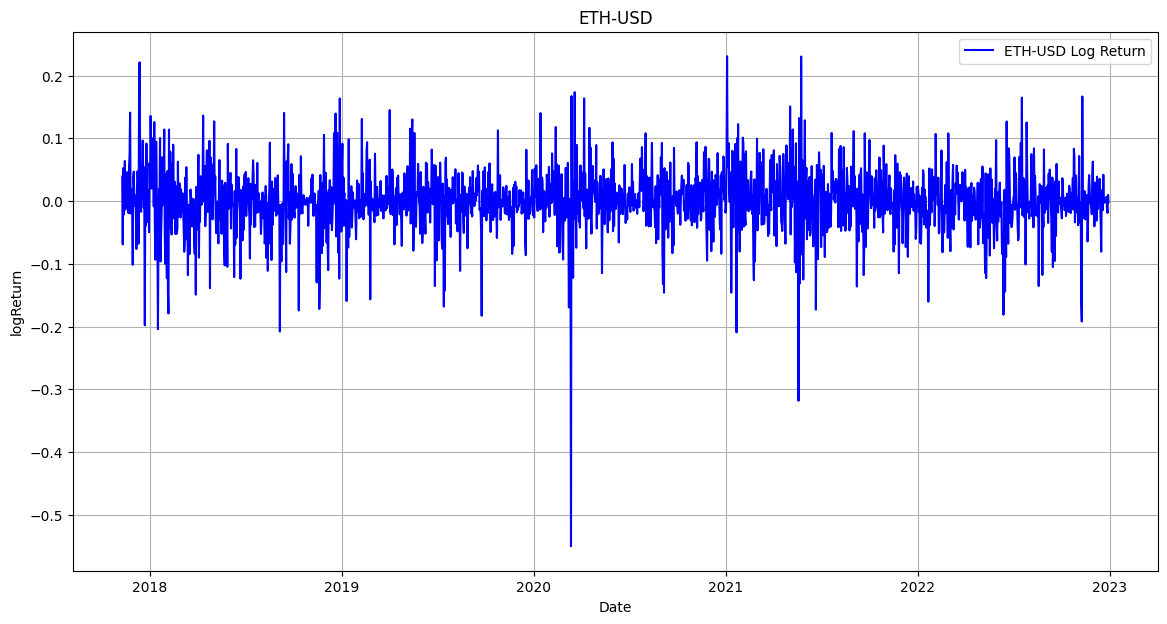

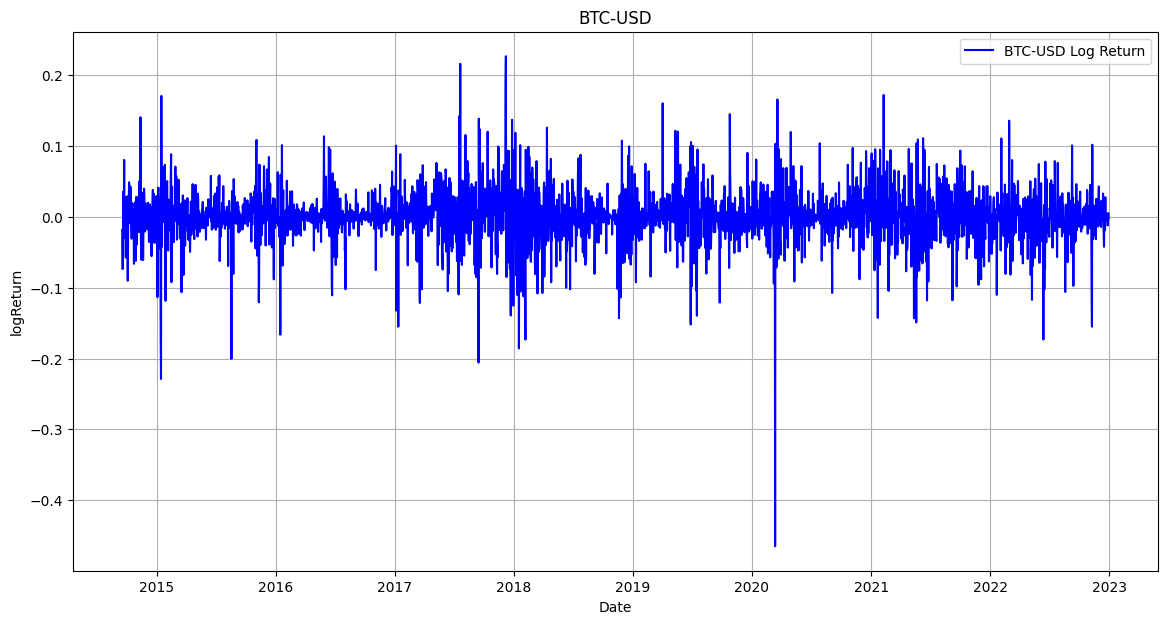

In [73]:
# Plotar o retorno logaritmo de ambos ao longo do tempo

plt.figure(figsize=(14, 7))
plt.plot(data_ETH['Log Return'], label='ETH-USD Log Return', color='blue')
plt.title('ETH-USD')
plt.xlabel('Date')
plt.ylabel('logReturn')
plt.grid(True)      
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(data_BTC['Log Return'], label='BTC-USD Log Return', color='blue')
plt.title('BTC-USD')
plt.xlabel('Date')
plt.ylabel('logReturn')
plt.grid(True)      
plt.legend()
plt.show()

Vamos agora criar uma coluna que armazene o valor predito para aquele instante de tempo e o valor predito de seu desvio padrão.

In [74]:
data_BTC['Predicted Value'] = data_BTC['Log Return'].rolling(window=N).mean().shift(1)
data_BTC['Predicted Risk'] = data_BTC['Log Return'].rolling(window=N).std().shift(1)
data_BTC['Sharpe Ratio'] = data_BTC['Predicted Value'] / data_BTC['Predicted Risk']
data_BTC['Squared Error'] = (data_BTC['Log Return'] - data_BTC['Predicted Value'])**2
data_BTC = data_BTC.dropna()
math.sqrt(data_BTC['Squared Error'].mean())


0.03881008004239096